In [75]:
!pip install tabpfn

  Using cached tabpfn-0.1.10-py3-none-any.whl (156 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/755.5 MB 60.7 kB/s eta 3:27:01^C
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/755.5 MB 61.0 kB/s eta 3:25:42
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [114]:
!pip install optuna

  Using cached optuna-3.5.0-py3-none-any.whl (413 kB)


  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)
     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/3.1 MB 53.1 kB/s eta 0:00:50^C
     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/3.1 MB 53.1 kB/s eta 0:00:50
ERROR: Operation cancelled by user


Library

In [1]:

from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import optuna
# from tabpfn import TabPFNClassifier

/tmp/ipykernel_28044/1038826202.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Data

In [39]:
data_domain = pd.read_csv("../data/dataset.csv")
data_img = pd.read_csv("../data/features(1).csv")
data_domain_valid = pd.read_csv("../data/dataset_valid.csv")
data_img_valid = pd.read_csv("../data/features_valid.csv")

In [40]:
data = pd.merge(data_domain, data_img, on="id", how="inner")
data_valid = pd.merge(data_domain_valid, data_img_valid, on="id", how="inner")

In [41]:
data_valid.columns

Index(['id', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max',
       'sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble',
       'sand_rate', 'coral_algae_rate', 'rock_rate', 'seagrass_rate',
       'microalgal_mats_rate', 'rubble_rate', 'seagrass_overlap', 'r_sum',
       'r_mean', 'r_var', 'g_sum', 'g_mean', 'g_var', 'b_sum', 'b_mean',
       'b_var', 'hog_sum', 'hog_mean', 'hog_var', 'sift_sum', 'sift_mean',
       'sift_var'],
      dtype='object')

In [42]:
columns_location = ['latitude_min', 'longitude_min', 'latitude_max', 'longitude_max']
columns_base = ['sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble']
columns_rate = ['sand_rate', 'coral_algae_rate', 'rock_rate', 'seagrass_rate', 'microalgal_mats_rate', 'rubble_rate']
columns_rgb = ['r_sum', 'r_mean', 'r_var', 'g_sum', 'g_mean', 'g_var', 'b_sum', 'b_mean', 'b_var', 'hog_sum']
columns_hog = ['hog_sum', 'hog_mean', 'hog_var']
columns_sift = ['sift_sum', 'sift_mean', 'sift_var']
target = "seagrass_overlap"
target_binary = "target_binary"

In [43]:
data['target_binary'] = data[target].apply(lambda x: 0 if x == 0 else 1)
data_valid['target_binary'] = data_valid[target].apply(lambda x: 0 if x == 0 else 1)

Feature

In [44]:
# カテゴリカル作成
for col in ['sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble']:
    data[col + '_onehot'] = data[col].apply(lambda x: 1 if x == 1 else 0)
for col in ['sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble']:
    data_valid[col + '_onehot'] = data_valid[col].apply(lambda x: 1 if x == 1 else 0)

In [45]:
# 位置情報×ドメイン作成
categories = ['seagrass', 'seagrass_rate', 'coral_algae', 'rock', 'microalgal_mats', 'rubble']
for category in categories:
    data[f'latitude×{category}'] = ((data['latitude_min'] + data['latitude_max']) / 2) * data[category]
    data[f'longitude×{category}'] = ((data['longitude_min'] + data['longitude_max']) / 2) * data[category]
for category in categories:
    data_valid[f'latitude×{category}'] = ((data_valid['latitude_min'] + data_valid['latitude_max']) / 2) * data_valid[category]
    data_valid[f'longitude×{category}'] = ((data_valid['longitude_min'] + data_valid['longitude_max']) / 2) * data_valid[category]

In [46]:
# seagrass関係をexponentialize
data['seagrass_exp'] = np.exp(data['seagrass'])
data['seagrass_rate_exp'] = np.exp(data['seagrass_rate'])
data_valid['seagrass_exp'] = np.exp(data_valid['seagrass'])
data_valid['seagrass_rate_exp'] = np.exp(data_valid['seagrass_rate'])

In [47]:
# 位置情報×画像
features = ['r_mean', 'g_mean', 'b_mean', 'hog_mean', 'sift_mean']

data['longitude_avg'] = (data['longitude_min'] + data['longitude_max']) / 2
data['latitude_avg'] = (data['latitude_min'] + data['latitude_max']) / 2

for feature in features:
    data[f'longitude_avg×{feature}'] = data['longitude_avg'] * data[feature]
    data[f'latitude_avg×{feature}'] = data['latitude_avg'] * data[feature]

data_valid['longitude_avg'] = (data_valid['longitude_min'] + data_valid['longitude_max']) / 2
data_valid['latitude_avg'] = (data_valid['latitude_min'] + data_valid['latitude_max']) / 2

for feature in features:
    data_valid[f'longitude_avg×{feature}'] = data_valid['longitude_avg'] * data_valid[feature]
    data_valid[f'latitude_avg×{feature}'] = data_valid['latitude_avg'] * data_valid[feature]

In [48]:
# ドメイン×画像
features = ['r_mean', 'g_mean', 'b_mean', 'hog_mean', 'sift_mean']
categories = ['sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble']

for feature in features:
    for category in categories:
        new_column_name = f'{feature}×{category}'
        data[new_column_name] = data[feature] * data[category]

for feature in features:
    for category in categories:
        new_column_name = f'{feature}×{category}'
        data_valid[new_column_name] = data_valid[feature] * data_valid[category]

In [49]:
X_data_base = data[columns_base]
X_data_base_valid = data_valid[columns_base]

X_data_rate_img = data[columns_rate + columns_rgb + columns_hog + columns_sift]
X_data_rate_img_valid = data_valid[columns_rate + columns_rgb + columns_hog + columns_sift]

In [50]:
# 教師無しクラスタリング

kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X_data_base)
data['base_3'] = kmeans_3.labels_
kmeans_3_valid = KMeans(n_clusters=3, random_state=0).fit(X_data_base_valid)
data_valid['base_3'] = kmeans_3_valid.predict(X_data_base_valid)

kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(X_data_base)
data['base_5'] = kmeans_5.labels_
kmeans_5_valid = KMeans(n_clusters=5, random_state=0).fit(X_data_base_valid)
data_valid['base_5'] = kmeans_5_valid.predict(X_data_base_valid)

kmeans_5_ = KMeans(n_clusters=5, random_state=0).fit(X_data_rate_img)
data['rate_img__5'] = kmeans_5_.labels_
kmeans_5_valid_ = KMeans(n_clusters=5, random_state=0).fit(X_data_rate_img_valid)
data_valid['rate_img_5'] = kmeans_5_valid_.predict(X_data_rate_img_valid)

kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(X_data_rate_img)
data['rate_img_7'] = kmeans_7.labels_
kmeans_7_valid = KMeans(n_clusters=7, random_state=0).fit(X_data_rate_img_valid)
data_valid['rate_img_7'] = kmeans_7_valid.predict(X_data_rate_img_valid)

In [53]:
data_valid.columns

Index(['id', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max',
       'sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble',
       'sand_rate', 'coral_algae_rate', 'rock_rate', 'seagrass_rate',
       'microalgal_mats_rate', 'rubble_rate', 'seagrass_overlap', 'r_sum',
       'r_mean', 'r_var', 'g_sum', 'g_mean', 'g_var', 'b_sum', 'b_mean',
       'b_var', 'hog_sum', 'hog_mean', 'hog_var', 'sift_sum', 'sift_mean',
       'sift_var', 'target_binary', 'sand_onehot', 'coral_algae_onehot',
       'rock_onehot', 'seagrass_onehot', 'microalgal_mats_onehot',
       'rubble_onehot', 'latitude×seagrass', 'longitude×seagrass',
       'latitude×seagrass_rate', 'longitude×seagrass_rate',
       'latitude×coral_algae', 'longitude×coral_algae', 'latitude×rock',
       'longitude×rock', 'latitude×microalgal_mats',
       'longitude×microalgal_mats', 'latitude×rubble', 'longitude×rubble',
       'seagrass_exp', 'seagrass_rate_exp', 'longitude_avg', 'latitude_avg',
    

In [54]:
columns_location = ['latitude_min', 'longitude_min', 'latitude_max', 'longitude_max']
columns_base = ['sand', 'coral_algae', 'rock', 'seagrass', 'microalgal_mats', 'rubble']
columns_rate = ['sand_rate', 'coral_algae_rate', 'rock_rate', 'seagrass_rate', 'microalgal_mats_rate', 'rubble_rate']
columns_rgb = ['r_sum', 'r_mean', 'r_var', 'g_sum', 'g_mean', 'g_var', 'b_sum', 'b_mean', 'b_var', 'hog_sum']
columns_hog = ['hog_sum', 'hog_mean', 'hog_var']
columns_sift = ['sift_sum', 'sift_mean', 'sift_var']
columns_onehot = ['sand_onehot', 'coral_algae_onehot', 'rock_onehot', 'seagrass_onehot', 'microalgal_mats_onehot', 'rubble_onehot']
columns_loc_base = ['latitude×seagrass', 'longitude×seagrass', 'latitude×seagrass_rate', 'longitude×seagrass_rate', 'latitude×coral_algae', 'longitude×coral_algae', 'latitude×rock', 'longitude×rock', 'latitude×microalgal_mats', 'longitude×microalgal_mats', 'latitude×rubble', 'longitude×rubble']
columns_exp = ['seagrass_exp', 'seagrass_rate_exp']
columns_loc_img = ['longitude_avg×r_mean', 'latitude_avg×r_mean', 'longitude_avg×g_mean', 'latitude_avg×g_mean', 'longitude_avg×b_mean', 'latitude_avg×b_mean', 'longitude_avg×hog_mean', 'latitude_avg×hog_mean', 'longitude_avg×sift_mean', 'latitude_avg×sift_mean']
columns_kmeans = ['base_3', 'base_5', 'rate_img_5', 'rate_img_7']
target = "seagrass_overlap"
target_binary = "target_binary"

Metrics and Bins

In [68]:
def generate_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    threshold: float,
) -> np.ndarray:
    """
    予測値と実際の値から混同行列を生成する関数。

    引数:
    - y_true: np.ndarray, テストデータセットの実際のクラスラベル。
    - y_pred: np.ndarray, テストデータセットに対する予測確率。
    - threshold: float, 予測確率をクラスラベルに変換するための閾値。

    戻り値:
    - np.ndarray: 生成された混同行列。
    """
    y_pred_label = (y_pred >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_label)
    
    return cm

LightGBM

In [17]:

def train_lightgbm_stratified_kfold(
    X: pd.DataFrame,
    y: pd.Series,
    columns_feature: List[str],
    target_binary: List[str],  # この実装では使用しないが、型情報を含める
    param: Dict[str, any],
    n_splits: int = 5,
) -> Tuple[List[lgb.Booster], List[float]]:
    """
    Stratified k-foldクロスバリデーションを使用してLightGBMモデルを訓練する関数。
    非均衡データを考慮して、各クラスの割合を保持する。

    引数:
    - X: pandas DataFrame, 特徴量データ。
    - y: pandas Series, 目的変数データ。
    - columns_feature: list, 特徴量のカラム名のリスト。
    - target_binary: list, 目的変数のカラム名のリスト（この関数では使用しないが、一貫性のために残す）。
    - param: dict, LightGBMモデルのパラメータ。
    - n_splits: int, クロスバリデーションの分割数。

    戻り値:
    - Tuple[List[lgb.Booster], List[float]]: 訓練済みLightGBMモデルのリストと各foldのlog lossスコアのリスト。
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models: List[lgb.Booster] = []
    scores: List[float] = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = (
            X.iloc[train_index][columns_feature],
            X.iloc[test_index][columns_feature],
        )
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm: lgb.Booster = lgb.train(
            param,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
        )

        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        score: float = log_loss(y_test, y_pred)
        scores.append(score)
        models.append(gbm)

    return models, scores

def predict_with_lightgbm(
    models: List[lgb.Booster],
    X_test: pd.DataFrame,
    columns_feature: List[str]
) -> np.ndarray:
    """
    訓練済みLightGBMモデルのリストを使用してテストデータセットの予測を行う関数。

    引数:
    - models: List[lgb.Booster], 訓練済みLightGBMモデルのリスト。
    - X_test: pandas DataFrame, テストデータセット。
    - columns_feature: list, 特徴量のカラム名のリスト。

    戻り値:
    - np.ndarray: テストデータセットの予測値の平均値。
    """
    predictions = []
    
    for model in models:
        y_pred = model.predict(X_test[columns_feature], num_iteration=model.best_iteration)
        predictions.append(y_pred)
    
    predictions_mean = np.mean(predictions, axis=0)
    
    return predictions_mean

In [33]:
params_lightgbm = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # 'multiclass' for multi-class classification
    'metric': 'binary_logloss',  # 'multi_logloss' for multi-class classification
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [18]:
def objective_lightgbm(trial, X, y, columns_feature, n_splits=5):
    """
    Optunaの試行に対する目的関数。LightGBMのハイパーパラメータを探索する。

    引数:
    - trial: optuna.trial.Trial オブジェクト
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_splits: クロスバリデーションの分割数

    戻り値:
    - 試行の平均log lossスコア
    """
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    _, scores = train_lightgbm_stratified_kfold(
        X, y, columns_feature, [], param, n_splits
    )
    return np.mean(scores)


def optimize_hyperparameters_lightgbm(
    X, y, columns_feature, n_trials=100, n_splits=5, timeout=300
):
    """
    Optunaを使用してLightGBMモデルのハイパーパラメータを最適化する。

    引数:
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_trials: 試行回数の上限
    - n_splits: クロスバリデーションの分割数
    - timeout: 探索にかける時間の上限（秒）

    戻り値:
    - 最適なハイパーパラメータの辞書
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda trial: objective_lightgbm(trial, X, y, columns_feature, n_splits),
        n_trials=n_trials,
        timeout=timeout,
    )

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best params: {study.best_trial.params}")

    return study.best_trial.params

In [19]:
optimize_hyperparameters_lightgbm(data_valid[columns_base], data_valid[target_binary], columns_base)

[I 2024-02-24 15:44:15,911] A new study created in memory with name: no-name-eb1abf46-b60a-4f5f-a0ef-03fc2fe9ec48
/tmp/ipykernel_28044/141605296.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
/tmp/ipykernel_28044/141605296.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
/tmp/ipykernel_28044/141605296.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform

Best trial: 0.16881344688513758
Best params: {'lambda_l1': 8.070513415854402, 'lambda_l2': 3.0097415890185105e-08, 'num_leaves': 118, 'feature_fraction': 0.5601215141918066, 'bagging_fraction': 0.6856053509279036, 'bagging_freq': 4, 'min_child_samples': 24}


{'lambda_l1': 8.070513415854402,
 'lambda_l2': 3.0097415890185105e-08,
 'num_leaves': 118,
 'feature_fraction': 0.5601215141918066,
 'bagging_fraction': 0.6856053509279036,
 'bagging_freq': 4,
 'min_child_samples': 24}

In [36]:
models_lightgbm, scores_lightgbm = train_lightgbm_stratified_kfold(X, y, columns_base, target_binary, params_lightgbm)

In [69]:
y_pred_lightgbm = predict_with_lightgbm(models_lightgbm, X_test, columns_base)
y_true = y_test.to_numpy()

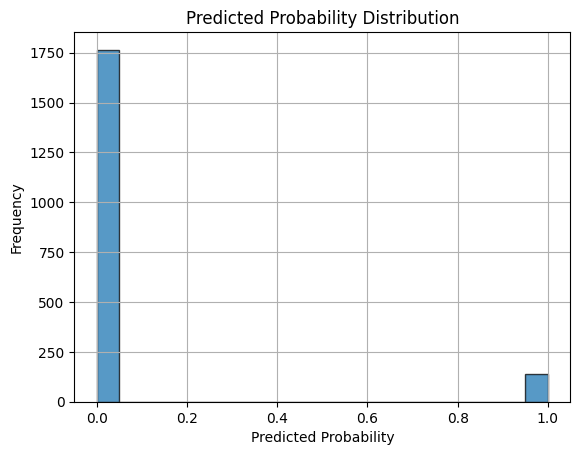

In [74]:
plt.hist(y_true, bins=20, alpha=0.75, edgecolor='black')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

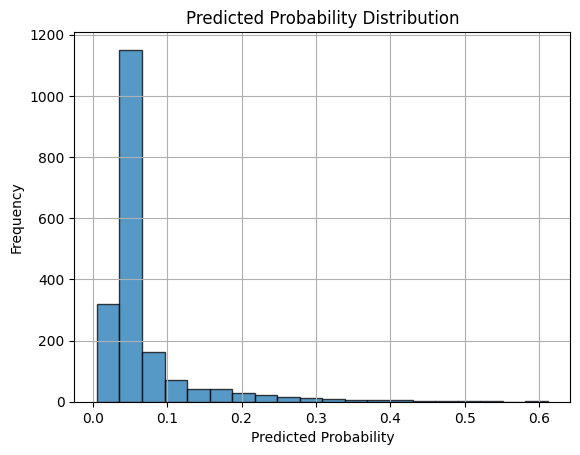

In [73]:
plt.hist(y_pred_lightgbm, bins=20, alpha=0.75, edgecolor='black')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [70]:
generate_confusion_matrix(y_true, y_pred_lightgbm, 0.5)

array([[1762,    3],
       [ 137,    0]])

Xgboost

In [59]:
def train_xgboost_stratified_kfold(
    X: pd.DataFrame,
    y: pd.Series,
    columns_feature: List[str],
    target_binary: List[str],  # この実装では使用しないが、型情報を含める
    param: Dict[str, any],
    n_splits: int = 5,
) -> Tuple[List[xgb.Booster], List[float]]:
    """
    Stratified k-foldクロスバリデーションを使用してXGBoostモデルを訓練する関数。
    非均衡データを考慮して、各クラスの割合を保持する。

    引数:
    - X: pandas DataFrame, 特徴量データ。
    - y: pandas Series, 目的変数データ。
    - columns_feature: list, 特徴量のカラム名のリスト。
    - target_binary: list, 目的変数のカラム名のリスト（この関数では使用しないが、一貫性のために残す）。
    - param: dict, XGBoostモデルのパラメータ。
    - n_splits: int, クロスバリデーションの分割数。

    戻り値:
    - Tuple[List[xgb.Booster], List[float]]: 訓練済みXGBoostモデルのリストと各foldのlog lossスコアのリスト。
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models: List[xgb.Booster] = []
    scores: List[float] = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = (
            X.iloc[train_index][columns_feature],
            X.iloc[test_index][columns_feature],
        )
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        bst: xgb.Booster = xgb.train(
            param,
            dtrain,
            num_boost_round=param.get("num_boost_round", 100),
            evals=[(dtrain, "train"), (dtest, "eval")],
            # early_stopping_rounds=param.get("early_stopping_rounds", 10),
            # verbose_eval=param.get("verbose_eval", 50),
        )

        y_pred = bst.predict(dtest)
        score: float = log_loss(y_test, y_pred)
        scores.append(score)
        models.append(bst)

    return models, scores


def predict_with_xgboost(models: List[xgb.Booster], X_test: pd.DataFrame, columns_feature: List[str]) -> np.ndarray:
    """
    訓練済みXGBoostモデルのリストを使用してテストデータセットの予測を行う関数。

    引数:
    - models: List[xgb.Booster], 訓練済みXGBoostモデルのリスト。
    - X_test: pandas DataFrame, テストデータセット。
    - columns_feature: list, 特徴量のカラム名のリスト。

    戻り値:
    - np.ndarray: テストデータセットの予測値の平均値。
    """
    # 各モデルからの予測値を格納するリスト
    predictions = []
    
    for model in models:
        dtest = xgb.DMatrix(X_test[columns_feature])
        y_pred = model.predict(dtest)
        predictions.append(y_pred)
    
    # 予測値の平均を計算
    predictions_mean = np.mean(predictions, axis=0)
    
    return predictions_mean

In [60]:
def objective_xgboost(trial, X, y, columns_feature, n_splits=5):
    """
    Optunaの試行に対する目的関数。XGBoostのハイパーパラメータを探索する。

    引数:
    - trial: optuna.trial.Trial オブジェクト
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_splits: クロスバリデーションの分割数

    戻り値:
    - 試行の平均log lossスコア
    """
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
    }

    _, scores = train_xgboost_stratified_kfold(
        X, y, columns_feature, [], param, n_splits
    )
    return np.mean(scores)


def optimize_hyperparameters_xgboost(
    X, y, columns_feature, n_trials=100, n_splits=5, timeout=300
):
    """
    Optunaを使用してXGBoostモデルのハイパーパラメータを最適化する。

    引数:
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_trials: 試行回数の上限
    - n_splits: クロスバリデーションの分割数
    - timeout: 探索にかける時間の上限（秒）

    戻り値:
    - 最適なハイパーパラメータの辞書
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda trial: objective_xgboost(trial, X, y, columns_feature, n_splits),
        n_trials=n_trials,
        timeout=timeout,
    )

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best params: {study.best_trial.params}")

    return study.best_trial.params

In [61]:
optimize_hyperparameters_xgboost(data[columns_base], data[target_binary], columns_base)

[I 2024-02-24 15:59:22,628] A new study created in memory with name: no-name-ac4986c7-6d46-4f07-9ff7-a9e8a1115b70
/tmp/ipykernel_28044/3574405256.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
/tmp/ipykernel_28044/3574405256.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
/

[0]	train-logloss:0.28929	eval-logloss:0.28931
[1]	train-logloss:0.28896	eval-logloss:0.28899
[2]	train-logloss:0.28860	eval-logloss:0.28865
[3]	train-logloss:0.28827	eval-logloss:0.28835
[4]	train-logloss:0.28792	eval-logloss:0.28803
[5]	train-logloss:0.28757	eval-logloss:0.28772
[6]	train-logloss:0.28724	eval-logloss:0.28740
[7]	train-logloss:0.28694	eval-logloss:0.28713
[8]	train-logloss:0.28661	eval-logloss:0.28682
[9]	train-logloss:0.28630	eval-logloss:0.28652
[10]	train-logloss:0.28598	eval-logloss:0.28623
[11]	train-logloss:0.28569	eval-logloss:0.28596
[12]	train-logloss:0.28538	eval-logloss:0.28568
[13]	train-logloss:0.28504	eval-logloss:0.28537
[14]	train-logloss:0.28475	eval-logloss:0.28511
[15]	train-logloss:0.28447	eval-logloss:0.28483
[16]	train-logloss:0.28419	eval-logloss:0.28458
[17]	train-logloss:0.28386	eval-logloss:0.28428
[18]	train-logloss:0.28359	eval-logloss:0.28403
[19]	train-logloss:0.28327	eval-logloss:0.28374
[20]	train-logloss:0.28300	eval-logloss:0.28350
[2

[I 2024-02-24 16:00:02,085] Trial 0 finished with value: 0.26690499174272747 and parameters: {'eta': 0.004912759013751147, 'max_depth': 6, 'subsample': 0.7670877943835539, 'colsample_bytree': 0.848361468082169, 'min_child_weight': 7, 'lambda': 2.935710414813769, 'alpha': 0.008581182861218457}. Best is trial 0 with value: 0.26690499174272747.


[0]	train-logloss:0.28928	eval-logloss:0.28934
[1]	train-logloss:0.28895	eval-logloss:0.28906


/tmp/ipykernel_28044/3574405256.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
/tmp/ipykernel_28044/3574405256.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

[2]	train-logloss:0.28858	eval-logloss:0.28877
[3]	train-logloss:0.28824	eval-logloss:0.28849
[4]	train-logloss:0.28786	eval-logloss:0.28818
[5]	train-logloss:0.28751	eval-logloss:0.28791
[6]	train-logloss:0.28717	eval-logloss:0.28764
[7]	train-logloss:0.28686	eval-logloss:0.28741
[8]	train-logloss:0.28648	eval-logloss:0.28711
[9]	train-logloss:0.28616	eval-logloss:0.28684
[10]	train-logloss:0.28581	eval-logloss:0.28655
[11]	train-logloss:0.28548	eval-logloss:0.28630
[12]	train-logloss:0.28517	eval-logloss:0.28605
[13]	train-logloss:0.28482	eval-logloss:0.28576
[14]	train-logloss:0.28451	eval-logloss:0.28551
[15]	train-logloss:0.28420	eval-logloss:0.28529
[16]	train-logloss:0.28391	eval-logloss:0.28505
[17]	train-logloss:0.28355	eval-logloss:0.28476
[18]	train-logloss:0.28327	eval-logloss:0.28452
[19]	train-logloss:0.28292	eval-logloss:0.28426
[20]	train-logloss:0.28263	eval-logloss:0.28402
[21]	train-logloss:0.28228	eval-logloss:0.28377
[22]	train-logloss:0.28195	eval-logloss:0.28350


[I 2024-02-24 16:00:40,434] Trial 1 finished with value: 0.26841053448074903 and parameters: {'eta': 0.00429997041703104, 'max_depth': 7, 'subsample': 0.689399873834518, 'colsample_bytree': 0.9813334908807003, 'min_child_weight': 1, 'lambda': 0.4627975799031548, 'alpha': 0.5251906016617869}. Best is trial 0 with value: 0.26690499174272747.
/tmp/ipykernel_28044/3574405256.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
/tmp/ipykernel_28044/3574405256.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:22: FutureWarning: suggest_uniform has 

[0]	train-logloss:0.28951	eval-logloss:0.28950
[1]	train-logloss:0.28943	eval-logloss:0.28943
[2]	train-logloss:0.28934	eval-logloss:0.28934
[3]	train-logloss:0.28926	eval-logloss:0.28927
[4]	train-logloss:0.28917	eval-logloss:0.28919
[5]	train-logloss:0.28909	eval-logloss:0.28911
[6]	train-logloss:0.28901	eval-logloss:0.28903
[7]	train-logloss:0.28892	eval-logloss:0.28895
[8]	train-logloss:0.28883	eval-logloss:0.28887
[9]	train-logloss:0.28874	eval-logloss:0.28878
[10]	train-logloss:0.28865	eval-logloss:0.28870
[11]	train-logloss:0.28857	eval-logloss:0.28863
[12]	train-logloss:0.28849	eval-logloss:0.28855
[13]	train-logloss:0.28840	eval-logloss:0.28847
[14]	train-logloss:0.28832	eval-logloss:0.28839
[15]	train-logloss:0.28823	eval-logloss:0.28832
[16]	train-logloss:0.28815	eval-logloss:0.28824
[17]	train-logloss:0.28806	eval-logloss:0.28816
[18]	train-logloss:0.28798	eval-logloss:0.28809
[19]	train-logloss:0.28790	eval-logloss:0.28801
[20]	train-logloss:0.28782	eval-logloss:0.28794
[2

[I 2024-02-24 16:01:41,872] Trial 2 finished with value: 0.28210079802632054 and parameters: {'eta': 0.0013615247289670218, 'max_depth': 9, 'subsample': 0.7571618711387393, 'colsample_bytree': 0.7680948172828955, 'min_child_weight': 2, 'lambda': 9.751702880888226, 'alpha': 0.004468968613911363}. Best is trial 0 with value: 0.26690499174272747.


[0]	train-logloss:0.28953	eval-logloss:0.28951


/tmp/ipykernel_28044/3574405256.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
/tmp/ipykernel_28044/3574405256.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

[1]	train-logloss:0.28946	eval-logloss:0.28945
[2]	train-logloss:0.28938	eval-logloss:0.28938
[3]	train-logloss:0.28932	eval-logloss:0.28933
[4]	train-logloss:0.28924	eval-logloss:0.28926
[5]	train-logloss:0.28918	eval-logloss:0.28920
[6]	train-logloss:0.28911	eval-logloss:0.28914
[7]	train-logloss:0.28903	eval-logloss:0.28907
[8]	train-logloss:0.28895	eval-logloss:0.28900
[9]	train-logloss:0.28888	eval-logloss:0.28893
[10]	train-logloss:0.28881	eval-logloss:0.28886
[11]	train-logloss:0.28874	eval-logloss:0.28880
[12]	train-logloss:0.28866	eval-logloss:0.28873
[13]	train-logloss:0.28859	eval-logloss:0.28866
[14]	train-logloss:0.28852	eval-logloss:0.28860
[15]	train-logloss:0.28845	eval-logloss:0.28854
[16]	train-logloss:0.28839	eval-logloss:0.28847
[17]	train-logloss:0.28831	eval-logloss:0.28840
[18]	train-logloss:0.28824	eval-logloss:0.28835
[19]	train-logloss:0.28817	eval-logloss:0.28828
[20]	train-logloss:0.28811	eval-logloss:0.28822
[21]	train-logloss:0.28803	eval-logloss:0.28815
[

[I 2024-02-24 16:02:59,435] Trial 3 finished with value: 0.28333415692799724 and parameters: {'eta': 0.001107873125080376, 'max_depth': 8, 'subsample': 0.6106798125610987, 'colsample_bytree': 0.8150837380415081, 'min_child_weight': 2, 'lambda': 5.422500111444353, 'alpha': 0.16410884856707386}. Best is trial 0 with value: 0.26690499174272747.


[0]	train-logloss:0.28825	eval-logloss:0.28841
[1]	train-logloss:0.28699	eval-logloss:0.28722
[2]	train-logloss:0.28547	eval-logloss:0.28585
[3]	train-logloss:0.28431	eval-logloss:0.28476
[4]	train-logloss:0.28296	eval-logloss:0.28362


/tmp/ipykernel_28044/3574405256.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-3, 0.1),
/tmp/ipykernel_28044/3574405256.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
/tmp/ipykernel_28044/3574405256.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

[5]	train-logloss:0.28175	eval-logloss:0.28251
[6]	train-logloss:0.28060	eval-logloss:0.28148
[7]	train-logloss:0.27942	eval-logloss:0.28035
[8]	train-logloss:0.27808	eval-logloss:0.27915
[9]	train-logloss:0.27697	eval-logloss:0.27811
[10]	train-logloss:0.27587	eval-logloss:0.27718
[11]	train-logloss:0.27478	eval-logloss:0.27607
[12]	train-logloss:0.27378	eval-logloss:0.27526
[13]	train-logloss:0.27264	eval-logloss:0.27436
[14]	train-logloss:0.27166	eval-logloss:0.27343
[15]	train-logloss:0.27075	eval-logloss:0.27262
[16]	train-logloss:0.26982	eval-logloss:0.27194
[17]	train-logloss:0.26875	eval-logloss:0.27101
[18]	train-logloss:0.26798	eval-logloss:0.27034
[19]	train-logloss:0.26706	eval-logloss:0.26960
[20]	train-logloss:0.26627	eval-logloss:0.26885
[21]	train-logloss:0.26536	eval-logloss:0.26806
[22]	train-logloss:0.26444	eval-logloss:0.26730
[23]	train-logloss:0.26372	eval-logloss:0.26666
[24]	train-logloss:0.26283	eval-logloss:0.26592
[25]	train-logloss:0.26204	eval-logloss:0.265

[I 2024-02-24 16:05:35,062] Trial 4 finished with value: 0.24825329034903967 and parameters: {'eta': 0.020731849490478793, 'max_depth': 5, 'subsample': 0.7745570964456191, 'colsample_bytree': 0.6902371409050212, 'min_child_weight': 4, 'lambda': 0.0865690416659273, 'alpha': 0.0016686161100794377}. Best is trial 4 with value: 0.24825329034903967.


Best trial: 0.24825329034903967
Best params: {'eta': 0.020731849490478793, 'max_depth': 5, 'subsample': 0.7745570964456191, 'colsample_bytree': 0.6902371409050212, 'min_child_weight': 4, 'lambda': 0.0865690416659273, 'alpha': 0.0016686161100794377}


{'eta': 0.020731849490478793,
 'max_depth': 5,
 'subsample': 0.7745570964456191,
 'colsample_bytree': 0.6902371409050212,
 'min_child_weight': 4,
 'lambda': 0.0865690416659273,
 'alpha': 0.0016686161100794377}

Catboost

In [62]:
def train_catboost_stratified_kfold(
    X: pd.DataFrame,
    y: pd.Series,
    columns_feature: List[str],
    target_binary: List[str],  # この実装では使用しないが、型情報を含める
    param: Dict[str, any],
    n_splits: int = 5,
) -> Tuple[List[CatBoostClassifier], List[float]]:
    """
    Stratified k-foldクロスバリデーションを使用してCatBoostモデルを訓練する関数。
    非均衡データを考慮して、各クラスの割合を保持する。

    引数:
    - X: pandas DataFrame, 特徴量データ。
    - y: pandas Series, 目的変数データ。
    - columns_feature: list, 特徴量のカラム名のリスト。
    - target_binary: list, 目的変数のカラム名のリスト（この関数では使用しないが、一貫性のために残す）。
    - param: dict, CatBoostモデルのパラメータ。
    - n_splits: int, クロスバリデーションの分割数。

    戻り値:
    - Tuple[List[CatBoostClassifier], List[float]]: 訓練済みCatBoostモデルのリストと各foldのlog lossスコアのリスト。
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models: List[CatBoostClassifier] = []
    scores: List[float] = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = (
            X.iloc[train_index][columns_feature],
            X.iloc[test_index][columns_feature],
        )
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_pool = Pool(X_train, y_train)
        test_pool = Pool(X_test, y_test)

        model = CatBoostClassifier(**param)
        model.fit(
            train_pool,
            eval_set=test_pool,
            # verbose=50,
            # early_stopping_rounds=100,
            use_best_model=True,
        )

        y_pred = model.predict_proba(X_test)[:, 1]
        score = log_loss(y_test, y_pred)
        scores.append(score)
        models.append(model)

    return models, scores


def predict_with_catboost(
    models: List[CatBoostClassifier], X_test: pd.DataFrame, columns_feature: List[str]
) -> np.ndarray:
    """
    訓練済みCatBoostモデルのリストを使用してテストデータセットの予測を行う関数。

    引数:
    - models: List[CatBoostClassifier], 訓練済みCatBoostモデルのリスト。
    - X_test: pandas DataFrame, テストデータセット。
    - columns_feature: list, 特徴量のカラム名のリスト。

    戻り値:
    - np.ndarray: テストデータセットの予測値の平均値。
    """
    predictions = []

    for model in models:
        y_pred = model.predict_proba(X_test[columns_feature])[:, 1]
        predictions.append(y_pred)

    predictions_mean = np.mean(predictions, axis=0)

    return predictions_mean

In [63]:
def objective_catboost(trial, X, y, columns_feature, n_splits=5):
    """
    Optunaの試行に対する目的関数。CatBoostのハイパーパラメータを探索する。

    引数:
    - trial: optuna.trial.Trial オブジェクト
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_splits: クロスバリデーションの分割数

    戻り値:
    - 試行の平均log lossスコア
    """
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 1, 20),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.01, 1.0
        ),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 10),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "verbose": False,
    }

    _, scores = train_catboost_stratified_kfold(
        X, y, columns_feature, [], param, n_splits
    )
    return np.mean(scores)


def optimize_hyperparameters_catboost(
    X, y, columns_feature, n_trials=100, n_splits=5, timeout=300
):
    """
    Optunaを使用してCatBoostモデルのハイパーパラメータを最適化する。

    引数:
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_trials: 試行回数の上限
    - n_splits: クロスバリデーションの分割数
    - timeout: 探索にかける時間の上限（秒）

    戻り値:
    - 最適なハイパーパラメータの辞書
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda trial: objective_catboost(trial, X, y, columns_feature, n_splits),
        n_trials=n_trials,
        timeout=timeout,
    )

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best params: {study.best_trial.params}")

    return study.best_trial.params

In [64]:
optimize_hyperparameters_catboost(data[columns_base], data[target_binary], columns_base)

[I 2024-02-24 16:06:04,153] A new study created in memory with name: no-name-08574b2c-f97f-4485-8205-3b615d23d841
/tmp/ipykernel_28044/11689719.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/tmp/ipykernel_28044/11689719.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "bagging_temperature": trial.suggest_loguniform(
/tmp/ipykernel_28044/11689719.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_logun

Best trial: 0.24501772249425371
Best params: {'iterations': 477, 'depth': 4, 'learning_rate': 0.03865988030236425, 'random_strength': 7, 'bagging_temperature': 0.021047069450234896, 'l2_leaf_reg': 0.002765756526827921, 'border_count': 152}


{'iterations': 477,
 'depth': 4,
 'learning_rate': 0.03865988030236425,
 'random_strength': 7,
 'bagging_temperature': 0.021047069450234896,
 'l2_leaf_reg': 0.002765756526827921,
 'border_count': 152}

RandomForest

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from typing import List, Dict, Tuple


def train_random_forest_stratified_kfold(
    X: pd.DataFrame,
    y: pd.Series,
    columns_feature: List[str],
    target_binary: List[str],  # この実装では使用しないが、型情報を含める
    param: Dict[str, any],
    n_splits: int = 5,
) -> Tuple[List[RandomForestClassifier], List[float]]:
    """
    Stratified k-foldクロスバリデーションを使用してRandom Forestモデルを訓練する関数。
    非均衡データを考慮して、各クラスの割合を保持する。

    引数:
    - X: pandas DataFrame, 特徴量データ。
    - y: pandas Series, 目的変数データ。
    - columns_feature: list, 特徴量のカラム名のリスト。
    - target_binary: list, 目的変数のカラム名のリスト（この関数では使用しないが、一貫性のために残す）。
    - param: dict, Random Forestモデルのパラメータ。
    - n_splits: int, クロスバリデーションの分割数。

    戻り値:
    - Tuple[List[RandomForestClassifier], List[float]]: 訓練済みRandom Forestモデルのリストと各foldのlog lossスコアのリスト。
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models: List[RandomForestClassifier] = []
    scores: List[float] = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = (
            X.iloc[train_index][columns_feature],
            X.iloc[test_index][columns_feature],
        )
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestClassifier(**param)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_test)[:, 1]
        score = log_loss(y_test, y_pred)
        scores.append(score)
        models.append(model)

    return models, scores


def predict_with_randomforest(
    models: List[RandomForestClassifier],
    X_test: pd.DataFrame,
    columns_feature: List[str],
) -> np.ndarray:
    """
    訓練済みRandom Forestモデルのリストを使用してテストデータセットの予測を行う関数。

    引数:
    - models: List[RandomForestClassifier], 訓練済みRandom Forestモデルのリスト。
    - X_test: pandas DataFrame, テストデータセット。
    - columns_feature: list, 特徴量のカラム名のリスト。

    戻り値:
    - np.ndarray: テストデータセットの予測値の平均値。
    """
    predictions = []

    for model in models:
        y_pred = model.predict_proba(X_test[columns_feature])[:, 1]
        predictions.append(y_pred)

    predictions_mean = np.mean(predictions, axis=0)

    return predictions_mean

In [66]:
def objective_random_forest(trial, X, y, columns_feature, n_splits=5):
    """
    Optunaの試行に対する目的関数。Random Forestのハイパーパラメータを探索する。

    引数:
    - trial: optuna.trial.Trial オブジェクト
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_splits: クロスバリデーションの分割数

    戻り値:
    - 試行の平均log lossスコア
    """
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 6, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60),
        "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
    }

    _, scores = train_random_forest_stratified_kfold(
        X, y, columns_feature, [], param, n_splits
    )
    return np.mean(scores)


def optimize_hyperparameters_random_forest(
    X, y, columns_feature, n_trials=100, n_splits=5, timeout=300
):
    """
    Optunaを使用してRandom Forestモデルのハイパーパラメータを最適化する。

    引数:
    - X, y: 訓練データ
    - columns_feature: 特徴量のカラム名のリスト
    - n_trials: 試行回数の上限
    - n_splits: クロスバリデーションの分割数
    - timeout: 探索にかける時間の上限（秒）

    戻り値:
    - 最適なハイパーパラメータの辞書
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda trial: objective_random_forest(trial, X, y, columns_feature, n_splits),
        n_trials=n_trials,
        timeout=timeout,
    )

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best params: {study.best_trial.params}")

    return study.best_trial.params

In [67]:
optimize_hyperparameters_random_forest(data[columns_base], data[target_binary], columns_base)

[I 2024-02-24 16:11:31,170] A new study created in memory with name: no-name-4eb6fb01-2d03-4360-9458-aaafb02474c0
/tmp/ipykernel_28044/142444984.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
[I 2024-02-24 16:12:04,717] Trial 0 finished with value: 0.2459574769546644 and parameters: {'n_estimators': 977, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.16692787524978514}. Best is trial 0 with value: 0.2459574769546644.
/tmp/ipykernel_28044/142444984.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
[I 2024-02-24 16:12:38,734] Trial 1 f

Best trial: 0.24564570830903346
Best params: {'n_estimators': 905, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 0.24598965635859815}


{'n_estimators': 905,
 'max_depth': 9,
 'min_samples_split': 6,
 'min_samples_leaf': 7,
 'max_features': 0.24598965635859815}

Pseudo Labeling
→一度コードを回して、結果を_pseudo_1, pseudo_2と名前を付けて繰り返す

Ensemble

In [68]:
def average_of_dataframes(dfs: List[pd.DataFrame]) -> pd.DataFrame:
    """
    3つのDataFrameの平均値を計算して新しいDataFrameとして返す関数。

    引数:
    - dfs: List[pd.DataFrame], 平均を取るDataFrameのリスト。

    戻り値:
    - pd.DataFrame: 入力されたDataFrameの平均値を含む新しいDataFrame。
    """
    # 全てのDataFrameを確認して同じ形状（行と列）であることを確認
    if not all(dfs[0].shape == df.shape for df in dfs):
        raise ValueError("All DataFrames must have the same shape.")
    
    # DataFrameの平均を計算
    df_mean = pd.concat(dfs).groupby(level=0).mean()

    return df_mean